In [14]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### Define tools and model

In [15]:
import os

print(os.getcwd())
os.chdir('../')

c:\Users\Hp\Desktop\RAG_PROJECT


In [16]:
os.getcwd()

'c:\\Users\\Hp\\Desktop'

In [17]:
from src.retriever import github_project_retriever
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from dotenv import load_dotenv


load_dotenv()

llm=ChatGroq(model="llama-3.3-70b-versatile")

@tool
def github_tool(query: str) -> str:
    """Searches the GitHub project for relevant information."""
    return github_project_retriever(query)

tools=[github_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

### Define model node

In [18]:
from langchain_core.messages import SystemMessage

def llm_call(state: dict):
    """
    LLM call node for the Graph RAG.

    The LLM decides whether to respond directly (normal chat)
    or to call the `github_project_retriever` tool to fetch 
    relevant information about my GitHub projects.

    State must contain:
      - messages: list of conversation messages.
      - llm_calls (optional): integer counter of how many times the LLM has been called.

    Returns:
      dict with updated "messages" and incremented "llm_calls".
    """

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=(
                            "You are a helpful assistant. You can answer general questions "
                            "and also help the user by retrieving information about my GitHub "
                            "projects using the `github_project_retriever` tool when relevant. "
                            "Always return answers in clear, well-structured Markdown."
                        )
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get("llm_calls", 0) + 1,
    }


### Define tool node

In [19]:
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [ ]:

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END

### Build and compile the agent

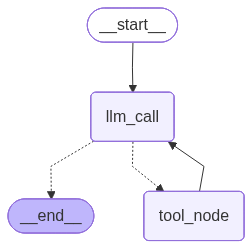

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:RAGPipeline:✓ Connected to Pinecone index: github-index
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:RAGPipeline:✓ Loaded embedder: sentence-transformers/all-MiniLM-L6-v2 on cpu
INFO:sentence_transformers.cross_encoder.CrossEncoder:Use pytorch device: cpu
INFO:RAGPipeline:✓ Loaded reranker: cross-encoder/ms-marco-MiniLM-L-2-v2
INFO:RAGPipeline:✓ Generated 3 fusion queries
INFO:RAGPipeline:  Query 1: SQL
INFO:RAGPipeline:  Query 2: Structured Query Language tutorials and guides
INFO:RAGPipeline:  Query 3: Database management using SQL programming and development
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


================================ Human Message =================================

Projects where i used SQL
================================== Ai Message ==================================

To find projects where you used SQL, I can search your GitHub projects.
Tool Calls:
  github_tool (04b6906qs)
 Call ID: 04b6906qs
  Args:
    query: SQL
================================= Tool Message =================================

| Repo Name | URL | Technologies | Description |
| --- | --- | --- | --- |
| DATA-ANALYSIS-SQL | [https://github.com/cleavestone/DATA-ANALYSIS-SQL](https://github.com/cleavestone/DATA-ANALYSIS-SQL) | MySQL, PostgreSQL, Python, Faker | SQL practice project with realistic datasets |
| Northwind-Sales-Analysis | [https://github.com/cleavestone/Northwind-Sales-Analysis](https://github.com/cleavestone/Northwind-Sales-Analysis) | Power BI, SQL Server, Power Query, DAX | Analyzes Northwind database sales data |
| ETL | [https://github.com/cleavestone/ETL](https://github.com/c

In [21]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Projects where i used SQL")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()